In [467]:
# Data Set voorbereiden
import warnings
import pandas as pd
import pyodbc
warnings.simplefilter('ignore')

DBAdventureWorks = {"servername": "localhost\SQLEXPRESS",
      "database": "AdventureWorks2019"}
DBaenc = {"servername": "localhost\SQLEXPRESS",
      "database": "aenc"}
DBNorthwind = {"servername": "localhost\SQLEXPRESS",
      "database": "Northwind"}


connAdventureWorks = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBAdventureWorks['servername'] + 
                             ';DATABASE=' + DBAdventureWorks['database'] + ';Trusted_Connection=yes')
connAenC = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBaenc['servername'] + 
                             ';DATABASE=' + DBaenc['database'] + ';Trusted_Connection=yes')
connNorthwind = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBNorthwind['servername'] + 
                             ';DATABASE=' + DBNorthwind['database'] + ';Trusted_Connection=yes')

export_cursorAdventureWorks = connAdventureWorks.cursor()
export_cursoraenc = connAenC.cursor()
export_cursorNorthwind = connNorthwind.cursor()


# data selecteren

In [468]:
# Laad de data
adventureworks_customers = pd.read_sql_query("SELECT * FROM Sales.Customer", connAdventureWorks)
adventureworks_sales = pd.read_sql_query("SELECT * FROM Sales.SalesOrderDetail", connAdventureWorks)
adventureworks_order_header = pd.read_sql_query("SELECT * FROM Sales.SalesOrderHeader", connAdventureWorks)

aenc_customers = pd.read_sql_query("SELECT * FROM customer", connAenC)
aenc_sales = pd.read_sql_query("SELECT * FROM sales_order_item", connAenC)
aenc_order_header = pd.read_sql_query("SELECT * FROM sales_order", connAenC)

northwind_customers = pd.read_sql_query("SELECT * FROM Customers", connNorthwind)
northwind_sales = pd.read_sql_query("SELECT * FROM [Order Details]", connNorthwind)
northwind_order_header = pd.read_sql_query("SELECT * FROM Orders", connNorthwind)

# Geografische gegevens selecteren
adventureworks_address = pd.read_sql_query("SELECT * FROM Person.Address", connAdventureWorks)




In [469]:
# #converteer aenc_sales quantity kolom naar int64
aenc_sales = aenc_sales[pd.to_numeric(aenc_sales['quantity'], errors='coerce').notna()]
aenc_sales['Quantity'] = aenc_sales['quantity'].astype('int64')


# data preprocessing

In [470]:
#voeg city toe aan adventureworks_order_header
adventureworks_order_header = pd.merge(adventureworks_order_header, adventureworks_address, left_on='ShipToAddressID',right_on='AddressID',suffixes=('_adventureworks', '_header'))
adventureworks_customers = pd.merge(adventureworks_order_header,adventureworks_customers, on='CustomerID')
# Voeg bron aan dataframes toe
adventureworks_customers['Source'] = 'AdventureWorks2019'
aenc_customers['Source'] = 'AenC'
northwind_customers['Source'] = 'Northwind'

# Normaliseer kolomnamen
adventureworks_customers.rename(columns={'CustomerID': 'CustomerID', 'AccountNumber': 'AccountNumber'}, inplace=True)
aenc_customers.rename(columns={'id': 'CustomerID','city' : 'City'}, inplace=True)
northwind_customers.rename(columns={'CustomerID': 'CustomerID'}, inplace=True)

# Combineer klantdata
customers = pd.concat([adventureworks_customers[['CustomerID','City','Source']],
                       aenc_customers[['CustomerID','City','Source']],
                       northwind_customers[['CustomerID','City','Source']]],
                      ignore_index=True)

# Normaliseer en combineer sales data met order headers
adventureworks_sales = adventureworks_sales.merge(adventureworks_order_header[['SalesOrderID','CustomerID']], on='SalesOrderID', suffixes=('_adventureworks', '_header'))
aenc_sales = aenc_sales.merge(aenc_order_header[['id', 'cust_id']], left_on='id', right_on='id', suffixes=('_aenc', '_header'))
northwind_sales = northwind_sales.merge(northwind_order_header[['OrderID', 'CustomerID']], on='OrderID', suffixes=('_northwind', '_header'))

adventureworks_sales.rename(columns={'SalesOrderID': 'OrderID', 'CustomerID': 'CustomerID', 'OrderQty': 'Quantity'}, inplace=True)
aenc_sales.rename(columns={'id': 'OrderID', 'prod_id': 'ProductID', 'quantity': 'Quantity', 'cust_id': 'CustomerID'}, inplace=True)
northwind_sales.rename(columns={'OrderID': 'OrderID', 'ProductID': 'ProductID', 'Quantity': 'Quantity'}, inplace=True)



In [471]:
#aenc_sales heeft Quantity 2 keer
aenc_sales = aenc_sales.loc[:,~aenc_sales.columns.duplicated()].copy()

aenc_sales['Quantity'] = aenc_sales['Quantity'].astype('int64')

In [472]:


# Nu de DataFrames samenvoegen
sales = pd.concat([adventureworks_sales[['OrderID', 'CustomerID', 'Quantity']],
                   aenc_sales[['OrderID', 'CustomerID', 'Quantity']],
                   northwind_sales[['OrderID', 'CustomerID', 'Quantity']]],
                  ignore_index=False)


In [473]:
import pandas as pd

# Groepeer data van verschiellende bronnen
sales = pd.concat([adventureworks_sales[['OrderID', 'CustomerID', 'Quantity']],
                   aenc_sales[['OrderID', 'CustomerID', 'Quantity']],
                   northwind_sales[['OrderID', 'CustomerID', 'Quantity']]],
                  ignore_index=True)

# Groepeer data per klant
customer_sales = sales.groupby('CustomerID').agg({'Quantity': 'sum'}).reset_index()
customer_sales.rename(columns={'Quantity': 'TotalPurchases'}, inplace=True)

# Voeg dataframes samen
customers = customers.merge(customer_sales, on='CustomerID', how='left')

# Drop rijen met missende waarden
customers.dropna(subset=['TotalPurchases'], inplace=True)

# Voeg dummy variabelen toe voor Source
customers = pd.get_dummies(customers, columns=['Source'], drop_first=True)

#Toon het eerste aantal rijen in de dataset
print(customers.head())


  CustomerID            City  TotalPurchases  Source_AenC  Source_Northwind
0      29825         Austell          1207.0        False             False
1      29672         Suwanee            14.0        False             False
2      29734         Toronto          1236.0        False             False
3      29994         Toronto          1408.0        False             False
4      29565  Trabuco Canyon            14.0        False             False


# Clustering model trainen

In [480]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Schaal de data
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers[['TotalPurchases']])

# Train K-Means model
clustercount = 8

kmeans = KMeans(n_clusters=clustercount, random_state=42)
customers['Cluster'] = kmeans.fit_predict(customers_scaled)

# Bekijk de eerste paar regels van de gesegmenteerde dataset
print(customers.head())

  CustomerID            City  TotalPurchases  Source_AenC  Source_Northwind  \
0      29825         Austell          1207.0        False             False   
1      29672         Suwanee            14.0        False             False   
2      29734         Toronto          1236.0        False             False   
3      29994         Toronto          1408.0        False             False   
4      29565  Trabuco Canyon            14.0        False             False   

   Cluster  
0        5  
1        0  
2        5  
3        1  
4        0  


# Data visualiseren

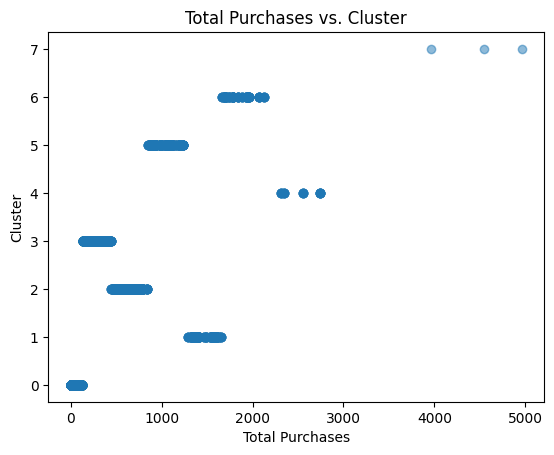

In [481]:
import matplotlib.pyplot as plt

# Scatter plot of Total Purchases vs. Cluster
plt.scatter(customers['TotalPurchases'], customers['Cluster'], alpha=0.5)
plt.xlabel('Total Purchases')
plt.ylabel('Cluster')
plt.title('Total Purchases vs. Cluster')

# Set y-axis to display integer values only
plt.yticks(range(clustercount))

plt.show()